<a href="https://colab.research.google.com/github/wlg100/numseqcont_circuit_expms/blob/main/nb_templates/circuit_expms_template.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" align="left"/></a>&nbsp;or in a local notebook.

This will save files to your local machine if `save_files` is set to True.

# Setup

In [1]:
%%capture
%pip install git+https://github.com/neelnanda-io/TransformerLens.git

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import tqdm.notebook as tqdm
import random
from pathlib import Path
# import plotly.express as px
from torch.utils.data import DataLoader

from jaxtyping import Float, Int
from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

import pickle
from google.colab import files

import matplotlib.pyplot as plt
import statistics

In [3]:
import transformer_lens
import transformer_lens.utils as utils
from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from transformer_lens import HookedTransformer, HookedTransformerConfig, FactoredMatrix, ActivationCache

We turn automatic differentiation off, to save GPU memory, as this notebook focuses on model inference not model training.

In [4]:
torch.set_grad_enabled(False)

In [5]:
save_files = True

# Load Model

In [6]:
from transformers import LlamaForCausalLM, LlamaTokenizer

In [7]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [8]:
LLAMA_2_7B_CHAT_PATH = "meta-llama/Llama-2-7b-chat-hf"

tokenizer = LlamaTokenizer.from_pretrained(LLAMA_2_7B_CHAT_PATH)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

In [9]:
hf_model = LlamaForCausalLM.from_pretrained(LLAMA_2_7B_CHAT_PATH, low_cpu_mem_usage=True)

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

In [10]:
import transformer_lens.utils as utils
from transformer_lens.hook_points import HookPoint
from transformer_lens import HookedTransformer

In [11]:
model = HookedTransformer.from_pretrained(
    LLAMA_2_7B_CHAT_PATH,
    hf_model = hf_model,
    tokenizer = tokenizer,
    device = "cpu",
    fold_ln = False,
    center_writing_weights = False,
    center_unembed = False,
)

del hf_model

model = model.to("cuda" if torch.cuda.is_available() else "cpu")

Loaded pretrained model meta-llama/Llama-2-7b-chat-hf into HookedTransformer
Moving model to device:  cuda


# Import functions from repo

In [12]:
!git clone https://github.com/apartresearch/seqcont_circuits.git
%cd /content/seqcont_circuits/src/iter_node_pruning

Cloning into 'seqcont_circuits'...
remote: Enumerating objects: 909, done.
remote: Counting objects: 100% (375/375), done.
remote: Compressing objects: 100% (243/243), done.
remote: Total 909 (delta 208), reused 284 (delta 121), pack-reused 534
Receiving objects: 100% (909/909), 17.08 MiB | 10.25 MiB/s, done.
Resolving deltas: 100% (571/571), done.
/content/seqcont_circuits/src/iter_node_pruning


In [13]:
# from dataset import Dataset
from metrics import *
from head_ablation_fns import *
from mlp_ablation_fns import *
from node_ablation_fns import *
from loop_node_ablation_fns import *

# Generate dataset with multiple prompts

In [14]:
# corr_tokenIDs is list of lists. Each list represents the "next" correct token
# within each list is the correct tokID for each prompt in the dataset
# each prompt has an item for the "next" corr token, but this should be a list now that there's multiple

# original with just one ans:
# eg. [tokenizer.encode(prompt["corr"])[-1] for prompt in prompts_list]
# [29945, 29953, 29955, 29947, 29929]

# ans_two_dataset

In [15]:
class Dataset:
    def __init__(self, prompts, tokenizer, ansLen):  # , S1_is_first=False
        self.prompts = prompts
        self.tokenizer = tokenizer
        self.ansLen = ansLen

        self.N = len(prompts)
        self.max_len = max(
            [
                len(self.tokenizer(prompt["text"]).input_ids)
                for prompt in self.prompts
            ]
        )
        all_ids = [0 for prompt in self.prompts] # only 1 template
        all_ids_ar = np.array(all_ids)
        self.groups = []
        for id in list(set(all_ids)):
            self.groups.append(np.where(all_ids_ar == id)[0])

        texts = [ prompt["text"] for prompt in self.prompts ]
        self.toks = torch.Tensor(self.tokenizer(texts, padding=True).input_ids).type(
            torch.int
        )

        self.corr_tokenIDs = []
        for ansPos in range(len(self.prompts[0]['corr'])):
            ansPos_corrTokIDS = [] # this is the inner list. each member is a promptID
            for promptID in range(len(self.prompts)):
                tokID = self.tokenizer.encode(self.prompts[promptID]['corr'][ansPos])[2:][0] # 2: to skip padding <s> and ''
                ansPos_corrTokIDS.append(tokID)
            self.corr_tokenIDs.append(ansPos_corrTokIDS)

        self.incorr_tokenIDs = []
        for ansPos in range(len(self.prompts[0]['incorr'])):
            ansPos_incorrTokIDS = [] # this is the inner list. each member is a promptID
            for promptID in range(len(self.prompts)):
                tokID = self.tokenizer.encode(self.prompts[promptID]['incorr'][ansPos])[2:][0]
                ansPos_incorrTokIDS.append(tokID)
            self.incorr_tokenIDs.append(ansPos_incorrTokIDS)

        # self.corr_tokenIDs = [
        #     # self.tokenizer.encode(" " + prompt["corr"])[0] for prompt in self.prompts
        #     self.tokenizer.encode(prompt["corr"])[-1] for prompt in self.prompts
        # ]
        # self.incorr_tokenIDs = [
        #     # self.tokenizer.encode(" " + prompt["incorr"])[0] for prompt in self.prompts
        #     self.tokenizer.encode(prompt["incorr"])[-1] for prompt in self.prompts
        # ]

        pos_dict = {}
        list_tokens = tokenizer.tokenize((prompts[0]["text"]))
        for i, tok_as_str in enumerate(list_tokens):
            pos_dict['S'+str(i)] = i

        # word_idx: for every prompt, find the token index of each target token and "end"
        # word_idx is a tensor with an element for each prompt. The element is the targ token's ind at that prompt
        self.word_idx = {}
        # for targ in [key for key in self.prompts[0].keys() if (key != 'text' and key != 'corr' and key != 'incorr')]:
        for targ in [key for key in pos_dict]:
            targ_lst = []
            for prompt in self.prompts:
                input_text = prompt["text"]
                tokens = self.tokenizer.tokenize(input_text)
                target_index = pos_dict[targ]
                targ_lst.append(target_index)
            self.word_idx[targ] = torch.tensor(targ_lst)

        targ_lst = []
        for prompt in self.prompts:
            input_text = prompt["text"]
            tokens = self.tokenizer.tokenize(input_text)
            end_token_index = len(tokens) - 1
            targ_lst.append(end_token_index)
        self.word_idx["end"] = torch.tensor(targ_lst)

    def __len__(self):
        return self.N

In [16]:
for i in range(6, 12):
    text = f"{i} {i+1} {i+2} {i+3} "
    ans_as_str = str(i+4)
    ans_as_tokstr = tokenizer.tokenize(ans_as_str)
    # print(ans_as_tokstr)

In [17]:
def generate_prompts_list(x ,y):
    prompts_list = []
    for i in range(x, y):
        prompt_dict = {
            'text': f"{i} {i+1} {i+2} {i+3} "
        }
        prompt_dict['corr'] = tokenizer.tokenize(str(i+4))[1:]  # ans_as_tokstr
        prompt_dict['incorr'] = tokenizer.tokenize(str(i+3))[1:]

        list_tokens = tokenizer.tokenize(prompt_dict['text'])
        for i, tok_as_str in enumerate(list_tokens):
            # if tok_as_str == '▁':
            #     prompt_dict['S'+str(i)] = ' '
            # else:
            #     prompt_dict['S'+str(i)] = tok_as_str
            prompt_dict['S'+str(i)] = tok_as_str
        prompts_list.append(prompt_dict)
    return prompts_list

prompts_by_ansLen = []
prompts_list = generate_prompts_list(1, 6)
prompts_by_ansLen.append(prompts_list)
# prompts_list = generate_prompts_list(6, 21)  # not same num of pos
prompts_list = generate_prompts_list(10, 25)
prompts_by_ansLen.append(prompts_list)
# prompts_list

In [18]:
len(prompts_by_ansLen[0]) + len(prompts_by_ansLen[1])

20

In [19]:
promptID, ansPos = 0, 0
tokenizer.encode(prompts_list[promptID]['corr'][ansPos])

[1, 29871, 29896]

In [20]:
tokenizer.decode(1)

'<s>'

In [21]:
tokenizer.decode(29871)

''

In [22]:
# corr_tokenIDs = []
# for ansPos in range(len(prompts_list[0]['corr'])):
#     ansPos_corrTokIDS = [] # this is the inner list. each member is a promptID
#     for promptID in range(len(prompts_list)):
#         tokID = tokenizer.encode(prompts_list[promptID]['corr'][ansPos])[2:][0] # 2: to skip padding <s> and ''
#         ansPos_corrTokIDS.append(tokID)
#     corr_tokenIDs.append(ansPos_corrTokIDS)
# corr_tokenIDs

In [23]:
import random

def generate_prompts_list_corr(list_of_prompts):
    outlist = []
    for prompt_dict in list_of_prompts:  # cannot use prompts_list as var, else will get global instead of fn arg (more priority)
        # print(prompt_dict)
        new_str = ''
        list_tokens = tokenizer.tokenize(prompt_dict['text'])
        for i, tok_as_str in enumerate(list_tokens):
            if tok_as_str.isdigit():
                new_str += str(random.randint(1, 9))
            else:
                new_str += ' '
        # r1 = random.randint(1, 9)
        # r2 = random.randint(1, 9)
        # while True:
        #     r3 = random.randint(1, 9)
        #     r4 = random.randint(1, 9)
        #     if r4 - 1 != r3:
        #         break
        # new_text = prompt_dict['text'].replace(prompt_dict['S1'], str(r1)).replace(prompt_dict['S2'], str(r2)).replace(prompt_dict['S3'], str(r3)).replace(prompt_dict['S4'], str(r4))
        new_prompt_dict = {
            'corr': prompt_dict['corr'],
            'incorr': prompt_dict['incorr'],
            # 'text': f"{r1} {r2} {r3} {r4} "
            'text': new_str
        }

        for i, tok_as_str in enumerate(list_tokens):
            # if tok_as_str == '▁':
            #     prompt_dict['S'+str(i)] = ' '
            # else:
            #     prompt_dict['S'+str(i)] = tok_as_str
            new_prompt_dict['S'+str(i)] = tok_as_str
        outlist.append(new_prompt_dict)
    return outlist

prompts_by_ansLen_corr = []
for clean_list in prompts_by_ansLen:
    # print(clean_list)
    prompts_list_2 = generate_prompts_list_corr(clean_list)
    prompts_by_ansLen_corr.append(prompts_list_2)

In [24]:
clean_datasets = []
for ansLen, prompts_list in enumerate(prompts_by_ansLen):
    dataset = Dataset(prompts_list, model.tokenizer, ansLen + 1)
    clean_datasets.append(dataset)

corrupted_datasets = []
for ansLen, prompts_list in enumerate(prompts_by_ansLen_corr):
    dataset = Dataset(prompts_list, model.tokenizer, ansLen + 1)
    corrupted_datasets.append(dataset)

In [25]:
corrupted_datasets[0].toks.shape

torch.Size([5, 10])

In [26]:
dataset.word_idx.keys()

dict_keys(['S0', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'end'])

# Get orig score

In [ ]:
clean_datasets

[<__main__.Dataset at 0x7d4ad01539d0>, <__main__.Dataset at 0x7d52416e2680>]

In [41]:
"""
Let N = ansLen
run the Nth dataset N times and sum up the logits for the N runs.
Then take the final summed logit score for these N datasets, and
take the mean over the number of samples for ALL datasets.
"""

all_correct_logits = torch.tensor([], device='cuda:0')
for ansLen, dataset in enumerate(clean_datasets):
    tokens = dataset.toks
    tokens = tokens.to("cuda" if torch.cuda.is_available() else "cpu")
    # corr_ans_tokLen = 0
    # corr_ans =
    # ans_so_far = ''
    # while True:
    for runID in range(ansLen + 1):
        model.reset_hooks(including_permanent=True)
        logits = model(tokens)

        ansTok_IDs = torch.tensor(dataset.corr_tokenIDs[ansLen])
        correct_logits = logits[range(logits.size(0)), -1, ansTok_IDs]  # not next_token, as that's what's pred, not the token to measure
        print(ansLen, runID, correct_logits)
        if runID == 0:
            total_logits_for_ansLen = correct_logits
        else:
            total_logits_for_ansLen += correct_logits
        # print(f"logit of new tok: {correct_logits}")

        # Define new input sequence, by appending the previously generated token
        # tokens = torch.cat([tokens, next_token[None, None]], dim=-1)
        next_token = logits[range(logits.size(0)), -1].argmax(dim=-1) # Get the predicted token at the end of our sequence

        # Reshape next_token to be a column vector, a 2D tensor with shape (15, 1).
        next_token_reshaped = next_token.view(-1, 1)

        # Concatenate along dimension 1 (columns)
        tokens = torch.cat((tokens, next_token_reshaped), dim=1)

        print(f"Sequence so far: {model.to_string(tokens[0, :])!r}")
        # corr_ans_tokLen += 1
        # next_char = model.to_string(next_token[0])
        # print(f"{tokens.shape[-1]+1}th char = {next_char!r}")
        # if next_char == '':
        #     next_char = ' '
        # ans_so_far += next_char
        # if ans_so_far == corr_ans:
        #     print('\nTotal logits: ', orig_score.item())
        #     break

    all_correct_logits = torch.cat((all_correct_logits, total_logits_for_ansLen))

orig_score = all_correct_logits.mean()

0 0 tensor([19.2083, 17.3797, 17.8889, 17.7881, 18.1708], device='cuda:0')
Sequence so far: '<s> 1 2 3 4 5'
1 0 tensor([11.5594, 11.3555, 10.0221,  9.0802,  9.8187,  9.9800,  9.3077, 10.4161,
        17.6115,  9.5897,  8.7311,  8.8378,  8.2261,  9.9216,  8.2259],
       device='cuda:0')
Sequence so far: '<s> 10 11 12 13 1'
1 1 tensor([21.6943, 22.0150, 21.7776, 22.5589, 20.7857, 20.7388, 20.9301, 19.6562,
        21.1408, 21.5440, 21.1607, 20.4155, 21.4599, 21.5681, 21.0668],
       device='cuda:0')
Sequence so far: '<s> 10 11 12 13 14'


In [ ]:
total_logits_for_ansLen

tensor([33.2537, 33.3705, 31.7997, 31.6390, 30.6045, 30.7188, 30.2377, 30.0723,
        38.7523, 31.1337, 29.8918, 29.2533, 29.6860, 31.4897, 29.2927],
       device='cuda:0')

In [ ]:
all_correct_logits

tensor([19.2083, 17.3797, 17.8889, 17.7881, 18.1708, 33.2537, 33.3705, 31.7997,
        31.6390, 30.6045, 30.7188, 30.2377, 30.0723, 38.7523, 31.1337, 29.8918,
        29.2533, 29.6860, 31.4897, 29.2927], device='cuda:0')

In [ ]:
orig_score

tensor(28.0816, device='cuda:0')

In [ ]:
import gc

del(logits)
torch.cuda.empty_cache()
gc.collect()

8

# ablation fns mult tok answers

In [ ]:
# def clean_gen(model, clean_text, corr_ans):
#     model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
#     tokens = model.to_tokens(clean_text).to(device)

#     total_score = 0
#     corr_ans_tokLen = 0
#     ans_so_far = ''
#     # while True:
#     for i in range(5):
#         print(f"Sequence so far: {model.to_string(tokens)[0]!r}")
#         logits = model(tokens)
#         next_token = logits[0, -1].argmax(dim=-1) # Get the predicted token at the end of our sequence
#         next_char = model.to_string(next_token)
#         if next_char == '':
#             next_char = ' '

#         correct_logits = logits[:, -1, next_token]
#         total_score += correct_logits
#         # print(f"logit of new tok: {correct_logits}")

#         ans_so_far += next_char
#         corr_ans_tokLen += 1
#         print(f"{tokens.shape[-1]+1}th char = {next_char!r}")
#         if ans_so_far == corr_ans:
#             print('\nTotal logits: ', total_score.item())
#             break

#         # Define new input sequence, by appending the previously generated token
#         tokens = torch.cat([tokens, next_token[None, None]], dim=-1)
#     return corr_ans_tokLen, total_score.item()

In [ ]:
# def ablate_then_gen(model, clean_text, corr_text, heads_not_ablate, mlps_not_ablate, corr_ans_tokLen):
#     tokens = model.to_tokens(clean_text).to(device)
#     prompts_list = generate_prompts_list_longer(clean_text, tokens)

#     corr_tokens = model.to_tokens(corr_text).to(device)
#     prompts_list_2 = generate_prompts_list_longer(corr_text, corr_tokens)

#     model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
#     pos_dict = {}
#     num_pos = len(model.tokenizer(prompts_list_2[0]['text']).input_ids)
#     for i in range(num_pos ):
#         pos_dict['S'+str(i)] = i
#     dataset_2 = Dataset(prompts_list_2, pos_dict, model.tokenizer)
#     model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

#     logits = model(tokens)
#     next_token = logits[0, -1].argmax(dim=-1)
#     next_char = model.to_string(next_token)

#     total_score = 0

#     for i in range(corr_ans_tokLen):
#         if next_char == '':
#             next_char = ' '

#         clean_text = clean_text + next_char
#         print(f"Sequence so far: {clean_text}")
#         print(f"{tokens.shape[-1]+1}th char = {next_char!r}")

#         tokens = torch.cat([tokens, next_token[None, None]], dim=-1)

#         # get new ablation dataset
#         # model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

#         # corr_text = corr_text + next_char
#         # # corr_tokens = model.to_tokens(corr_text).to(device)

#         # # corr_text = model.to_string(corr_tokens)[0]
#         # corr_tokens = torch.cat([corr_tokens, next_token[None, None]], dim=-1)
#         # prompts_list_2 = generate_prompts_list_longer(corr_text, corr_tokens)
#         # print(corr_text)
#         # # print(corr_tokens.shape)

#         # pos_dict = {}
#         # # for i in range(len(model.tokenizer.tokenize(prompts_list_2[0]['text']))):
#         # # for i in range(corr_tokens.shape[1]):
#         # num_pos = len(model.tokenizer(prompts_list_2[0]['text']).input_ids)
#         # # for i in range(num_pos + 1):
#         # for i in range(num_pos ):
#         #     pos_dict['S'+str(i)] = i

#         # # dataset_2 = Dataset(prompts_list_2, pos_dict, model.tokenizer)
#         # dataset_2 = Dataset(prompts_list_2, pos_dict, model.tokenizer, corr_tokens)

#         # model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

#         logits = model(tokens)
#         next_token = logits[0, -1].argmax(dim=-1) # Get the predicted token at the end of our sequence
#         next_char = model.to_string(next_token)

#         # new_score = get_logit_diff(logits, dataset)
#         corrTok_logits = logits[:, -1, next_token]
#         total_score += corrTok_logits
#         # print(f"corr logit of new char: {corrTok_logits}")
#     print('\nTotal corr logit: ', total_score.item())
#     return total_score.item()

# zero ablation functions

In [27]:
def get_heads_actv_mean(
    means_dataset: Dataset,
    model: HookedTransformer
) -> Float[Tensor, "layer batch seq head_idx d_head"]:
    '''
    Output: The mean activations of a head's output
    '''
    _, means_cache = model.run_with_cache(
        means_dataset.toks.long(),
        return_type=None,
        names_filter=lambda name: name.endswith("z"),
    )
    n_layers, n_heads, d_head = model.cfg.n_layers, model.cfg.n_heads, model.cfg.d_head
    batch, seq_len = len(means_dataset), means_dataset.max_len
    means = t.zeros(size=(n_layers, batch, seq_len, n_heads, d_head), device=model.cfg.device)

    # for layer in range(model.cfg.n_layers):
    #     z_for_this_layer: Float[Tensor, "batch seq head d_head"] = means_cache[utils.get_act_name("z", layer)]
    #     for template_group in means_dataset.groups:
    #         z_for_this_template = z_for_this_layer[template_group]
    #         z_means_for_this_template = einops.reduce(z_for_this_template, "batch seq head d_head -> seq head d_head", "mean")
    #         if z_means_for_this_template.shape[0] == 5:
    #             pdb.set_trace()
    #         means[layer, template_group] = z_means_for_this_template

    del(means_cache)

    return means

In [28]:
def mask_circ_heads(
    means_dataset: Dataset,
    model: HookedTransformer,
    circuit: Dict[str, List[Tuple[int, int]]],
    seq_pos_to_keep: Dict[str, str],
) -> Dict[int, Bool[Tensor, "batch seq head"]]:
    '''
    Output: for each layer, a mask of circuit components that should not be ablated
    '''
    heads_and_posns_to_keep = {}
    # batch, seq, n_heads = len(means_dataset), means_dataset.max_len, model.cfg.n_heads
    batch, seq, n_heads = len(means_dataset), len(circuit.keys()), model.cfg.n_heads
    print(seq)

    for layer in range(model.cfg.n_layers):

        mask = t.zeros(size=(batch, seq, n_heads))

        for (head_type, head_list) in circuit.items():
            seq_pos = seq_pos_to_keep[head_type]
            indices = means_dataset.word_idx[seq_pos] # modify this for key vs query pos. curr, this is query
            for (layer_idx, head_idx) in head_list:
                if layer_idx == layer:
                    # mask[:, indices, head_idx] = 1
                    mask[:, :, head_idx] = 1

        heads_and_posns_to_keep[layer] = mask.bool()

    return heads_and_posns_to_keep

In [29]:
def hook_func_mask_head(
    z: Float[Tensor, "batch seq head d_head"],
    hook: HookPoint,
    # components_to_keep: Dict[int, Bool[Tensor, "batch seq head"]],
    # means: Float[Tensor, "layer batch seq head d_head"],
    circuit: Dict[str, List[Tuple[int, int]]],
) -> Float[Tensor, "batch seq head d_head"]:
    '''
    Use this to not mask components
    '''
    # mask_for_this_layer = components_to_keep[hook.layer()].unsqueeze(-1).to(z.device)
    # z = t.where(mask_for_this_layer, z, means[hook.layer()])

    ###
    # heads_and_posns_to_keep = {}
    # batch, seq, n_heads = z.shape[0], z.shape[1], model.cfg.n_heads  # components_to_keep[0].shape[0] is batch

    # for layer in range(model.cfg.n_layers):

    #     mask = t.zeros(size=(batch, seq, n_heads))

    #     for (head_type, head_list) in circuit.items():
    #         # seq_pos = seq_pos_to_keep[head_type]
    #         # indices = means_dataset.word_idx[seq_pos] # modify this for key vs query pos. curr, this is query
    #         for (layer_idx, head_idx) in head_list:
    #             if layer_idx == layer:
    #                 # mask[:, indices, head_idx] = 1
    #                 mask[:, :, head_idx] = 1

    #     heads_and_posns_to_keep[layer] = mask.bool()
    ###
    mask_for_this_layer = t.zeros(size=(z.shape[0], z.shape[1], z.shape[2]))
    for (head_type, head_list) in circuit.items():
        # seq_pos = seq_pos_to_keep[head_type]
        # indices = means_dataset.word_idx[seq_pos] # modify this for key vs query pos. curr, this is query
        for (layer_idx, head_idx) in head_list:
            if layer_idx == hook.layer():
                # mask[:, indices, head_idx] = 1
                mask_for_this_layer[:, :, head_idx] = 1

    mask_for_this_layer = mask_for_this_layer.bool()
    mask_for_this_layer = mask_for_this_layer.unsqueeze(-1).to(z.device)  # d_model is 1; then is broadcast in where

    z = t.where(mask_for_this_layer, z, 0)

    return z

In [30]:
def add_ablation_hook_head(
    model: HookedTransformer,
    means_dataset: Dataset,
    circuit: Dict[str, List[Tuple[int, int]]],
    seq_pos_to_keep: Dict[str, str],
    is_permanent: bool = True,
) -> HookedTransformer:
    '''
    Ablate the model, except as components and positions to keep
    '''

    model.reset_hooks(including_permanent=True)
    means = get_heads_actv_mean(means_dataset, model)
    components_to_keep = mask_circ_heads(means_dataset, model, circuit, seq_pos_to_keep)

    hook_fn = partial(
        hook_func_mask_head,
        # components_to_keep=components_to_keep,
        # means=means,
        circuit=circuit,
    )

    model.add_hook(lambda name: name.endswith("z"), hook_fn, is_permanent=is_permanent)
    return model

In [31]:
# from dataset import Dataset
from transformer_lens import HookedTransformer, utils
from transformer_lens.hook_points import HookPoint
import einops
from functools import partial
import torch as t
from torch import Tensor
from typing import Dict, Tuple, List
from jaxtyping import Float, Bool

# from head_ablation_fns import *
# from mlp_ablation_fns import *

def add_ablation_hook_MLP_head(
    model: HookedTransformer,
    means_dataset: Dataset,
    heads_lst, mlp_lst,
    is_permanent: bool = True,
) -> HookedTransformer:
    CIRCUIT = {}
    SEQ_POS_TO_KEEP = {}
    # for i in range(len(model.tokenizer.tokenize(means_dataset.prompts[0]['text']))):
    # num_pos = len(model.tokenizer(means_dataset.prompts[0]['text']).input_ids)
    num_pos = len(tokenizer.tokenize(means_dataset.prompts[0]['text']))
    for i in range(num_pos ):
        CIRCUIT['S'+str(i)] = heads_lst
        # if i == len(model.tokenizer.tokenize(means_dataset.prompts[0]['text'])) - 1:
        # if i == num_pos - 1:
        #     SEQ_POS_TO_KEEP['S'+str(i)] = 'end'
        # else:
        SEQ_POS_TO_KEEP['S'+str(i)] = 'S'+str(i)

    model.reset_hooks(including_permanent=True)

    # Compute the mean of each head's output on the ABC dataset, grouped by template
    means = get_heads_actv_mean(means_dataset, model)
    # Convert this into a boolean map
    components_to_keep = mask_circ_heads(means_dataset, model, CIRCUIT, SEQ_POS_TO_KEEP)

    # Get a hook function which will patch in the mean z values for each head, at
    # all positions which aren't important for the circuit
    hook_fn = partial(
        hook_func_mask_head,
        # components_to_keep=components_to_keep,
        # means=means,
        circuit=CIRCUIT,
    )

    # Apply hook
    model.add_hook(lambda name: name.endswith("z"), hook_fn, is_permanent=is_permanent)

    # if all_entries_true(components_to_keep) == False:
    #     pdb.set_trace()
    ########################
    # CIRCUIT = {}
    # SEQ_POS_TO_KEEP = {}
    # # for i in range(len(model.tokenizer.tokenize(means_dataset.prompts[0]['text']))):
    # num_pos = len(model.tokenizer(means_dataset.prompts[0]['text']).input_ids)
    # for i in range(num_pos ):
    #     CIRCUIT['S'+str(i)] = mlp_lst
    #     # if i == len(model.tokenizer.tokenize(means_dataset.prompts[0]['text'])) - 1:
    #     # if i == num_pos - 1:
    #     #     SEQ_POS_TO_KEEP['S'+str(i)] = 'end'
    #     # else:
    #     SEQ_POS_TO_KEEP['S'+str(i)] = 'S'+str(i)

    # # Compute the mean of each head's output on the ABC dataset, grouped by template
    # means = get_MLPs_actv_mean(means_dataset, model)

    # # Convert this into a boolean map
    # components_to_keep = mask_circ_MLPs(means_dataset, model, CIRCUIT, SEQ_POS_TO_KEEP)

    # # Get a hook function which will patch in the mean z values for each head, at
    # # all positions which aren't important for the circuit
    # hook_fn = partial(
    #     hook_func_mask_mlp_out,
    #     components_to_keep=components_to_keep,
    #     means=means
    # )

    # model.add_hook(lambda name: name.endswith("mlp_out"), hook_fn, is_permanent=True)

    return model

In [32]:
def all_entries_true(tensor_dict):
    for key, tensor in tensor_dict.items():
        if not torch.all(tensor).item():
            return False
    return True

# Find Impt Attention Heads from Full

## test unablated run

Llama-2 has 32 heads per layer

In [42]:
lst = [(layer, head) for layer in range(32) for head in range(0, 32)]

all_correct_logits = torch.tensor([], device='cuda:0')
for ansLen, dataset in enumerate(clean_datasets):
    model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

    CIRCUIT = {}
    SEQ_POS_TO_KEEP = {}

    list_tokens = tokenizer.tokenize(dataset.prompts[0]['text'])
    for i, tok_as_str in enumerate(list_tokens):
        CIRCUIT['S'+str(i)] = lst
        SEQ_POS_TO_KEEP['S'+str(i)] = 'S'+str(i)
        # if i == len(list_tokens) - 1:
        #     SEQ_POS_TO_KEEP['S'+str(i)] = 'end'
        # else:
            # SEQ_POS_TO_KEEP['S'+str(i)] = 'S'+str(i)

    dataset_2 = corrupted_datasets[ansLen]
    model = add_ablation_hook_head(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)

    tokens = dataset.toks
    tokens = tokens.to("cuda" if torch.cuda.is_available() else "cpu")
    for runID in range(ansLen + 1):
        print(tokens.shape)
        logits = model(tokens)

        ansTok_IDs = torch.tensor(dataset.corr_tokenIDs[ansLen])
        correct_logits = logits[range(logits.size(0)), -1, ansTok_IDs]  # not next_token, as that's what's pred, not the token to measure
        print(ansLen, runID, correct_logits)
        if runID == 0:
            total_logits_for_ansLen = correct_logits
        else:
            total_logits_for_ansLen += correct_logits

        next_token = logits[range(logits.size(0)), -1].argmax(dim=-1) # Get the predicted token at the end of our sequence

        next_token_reshaped = next_token.view(-1, 1)
        tokens = torch.cat((tokens, next_token_reshaped), dim=1)

        print(f"Sequence so far: {model.to_string(tokens[0, :])!r}")
        if runID > 0 and runID < ansLen:
            i += 1
            CIRCUIT['S'+str(i)] = lst
            SEQ_POS_TO_KEEP['S'+str(i)] = 'S'+str(i)
            model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
            model = add_ablation_hook_head(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)

    all_correct_logits = torch.cat((all_correct_logits, total_logits_for_ansLen))

new_score = all_correct_logits.mean()
new_score

9
torch.Size([5, 10])
0 0 tensor([19.2083, 17.3797, 17.8889, 17.7881, 18.1708], device='cuda:0')
Sequence so far: '<s> 1 2 3 4 5'
13
torch.Size([15, 14])
1 0 tensor([11.5594, 11.3555, 10.0221,  9.0802,  9.8187,  9.9800,  9.3077, 10.4161,
        17.6115,  9.5897,  8.7311,  8.8378,  8.2261,  9.9216,  8.2259],
       device='cuda:0')
Sequence so far: '<s> 10 11 12 13 1'
torch.Size([15, 15])
1 1 tensor([21.6943, 22.0150, 21.7776, 22.5589, 20.7857, 20.7388, 20.9301, 19.6562,
        21.1408, 21.5440, 21.1607, 20.4155, 21.4599, 21.5681, 21.0668],
       device='cuda:0')
Sequence so far: '<s> 10 11 12 13 14'


tensor(28.0816, device='cuda:0')

In [43]:
print(f"Average logit difference (circuit / full) %: {100 * new_score / orig_score:.4f}")
new_score

Average logit difference (circuit / full) %: 100.0000


tensor(28.0816, device='cuda:0')

In [ ]:
import gc

del(logits)
torch.cuda.empty_cache()
gc.collect()

## run 20.17 ablated

In [45]:
lst = [(layer, head) for layer in range(32) for head in range(0, 32)]
lst.remove( (20, 17) )

all_correct_logits = torch.tensor([], device='cuda:0')
for ansLen, dataset in enumerate(clean_datasets):
    model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

    CIRCUIT = {}
    SEQ_POS_TO_KEEP = {}

    list_tokens = tokenizer.tokenize(dataset.prompts[0]['text'])
    for i, tok_as_str in enumerate(list_tokens):
        CIRCUIT['S'+str(i)] = lst
        SEQ_POS_TO_KEEP['S'+str(i)] = 'S'+str(i)
        # if i == len(list_tokens) - 1:
        #     SEQ_POS_TO_KEEP['S'+str(i)] = 'end'
        # else:
            # SEQ_POS_TO_KEEP['S'+str(i)] = 'S'+str(i)

    dataset_2 = corrupted_datasets[ansLen]
    model = add_ablation_hook_head(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)

    tokens = dataset.toks
    tokens = tokens.to("cuda" if torch.cuda.is_available() else "cpu")
    for runID in range(ansLen + 1):
        print(tokens.shape)
        logits = model(tokens)

        ansTok_IDs = torch.tensor(dataset.corr_tokenIDs[ansLen])
        correct_logits = logits[range(logits.size(0)), -1, ansTok_IDs]  # not next_token, as that's what's pred, not the token to measure
        print(ansLen, runID, correct_logits)
        if runID == 0:
            total_logits_for_ansLen = correct_logits
        else:
            total_logits_for_ansLen += correct_logits

        next_token = logits[range(logits.size(0)), -1].argmax(dim=-1) # Get the predicted token at the end of our sequence

        next_token_reshaped = next_token.view(-1, 1)
        tokens = torch.cat((tokens, next_token_reshaped), dim=1)

        print(f"Sequence so far: {model.to_string(tokens[0, :])!r}")
        if runID > 0 and runID < ansLen:
            i += 1
            CIRCUIT['S'+str(i)] = lst
            SEQ_POS_TO_KEEP['S'+str(i)] = 'S'+str(i)
            model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
            model = add_ablation_hook_head(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)

    all_correct_logits = torch.cat((all_correct_logits, total_logits_for_ansLen))

new_score = all_correct_logits.mean()
new_score / orig_score

9
torch.Size([5, 10])
0 0 tensor([18.8819, 16.2971, 16.5536, 16.6447, 17.0187], device='cuda:0')
Sequence so far: '<s> 1 2 3 4 5'
13
torch.Size([15, 14])
1 0 tensor([10.0875, 10.3275,  9.5509,  9.2796,  8.9772,  9.0321,  8.4929, 11.4023,
        16.5681, 10.4601,  8.8613,  8.9688,  8.2068,  8.6300,  7.7849],
       device='cuda:0')
Sequence so far: '<s> 10 11 12 13 1'
torch.Size([15, 15])
1 1 tensor([21.0560, 21.3628, 20.8120, 21.2928, 19.4318, 20.1190, 20.0881, 19.5155,
        20.8204, 20.8248, 20.5360, 20.0678, 20.1237, 20.6607, 20.7614],
       device='cuda:0')
Sequence so far: '<s> 10 11 12 13 14'


tensor(0.9606, device='cuda:0')

## run each

In [ ]:
def ablate_head_from_full(
        lst: List[Tuple[int, int]],
        model: HookedTransformer,
        dataset: Dataset,
        dataset_2: Dataset,
        orig_score: float,
        print_output: bool = True,
) -> float:
    # CIRCUIT contains the components to not ablate
    CIRCUIT = {}
    SEQ_POS_TO_KEEP = {}

    list_tokens = tokenizer.tokenize('1 2 3 4')
    for i, tok_as_str in enumerate(list_tokens):
        CIRCUIT['S'+str(i)] = lst
        SEQ_POS_TO_KEEP['S'+str(i)] = 'S'+str(i)
        if i == 7:
            SEQ_POS_TO_KEEP['S'+str(i)] = 'end'

    model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

    model = add_ablation_hook_head(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
    logits_minimal = model(dataset.toks)

    new_score = get_logit_diff(logits_minimal, dataset)
    if print_output:
        print(f"Average logit difference (circuit / full) %: {100 * new_score / orig_score:.4f}")
    return 100 * new_score / orig_score

In [ ]:
circ = [(layer, head) for layer in range(32) for head in range(0, 32)]
# to_loop = circ.copy() # (L,H) to remove
to_loop = [(layer, head) for layer in range(32) for head in range(0, 32)]

lh_scores = {}
for lh in to_loop:
    copy_circuit = circ.copy()
    copy_circuit.remove(lh)
    print("removed: " + str(lh))
    new_score = ablate_head_from_full(copy_circuit, model, dataset, dataset_2, orig_score, print_output=True).item()
    lh_scores[lh] = new_score

removed: (0, 0)
Average logit difference (circuit / full) %: 99.8669
removed: (0, 1)
Average logit difference (circuit / full) %: 100.6312
removed: (0, 2)
Average logit difference (circuit / full) %: 99.4772
removed: (0, 3)
Average logit difference (circuit / full) %: 100.8142
removed: (0, 4)
Average logit difference (circuit / full) %: 100.2262
removed: (0, 5)
Average logit difference (circuit / full) %: 100.0235
removed: (0, 6)
Average logit difference (circuit / full) %: 99.8446
removed: (0, 7)
Average logit difference (circuit / full) %: 99.8350
removed: (0, 8)
Average logit difference (circuit / full) %: 100.1723
removed: (0, 9)
Average logit difference (circuit / full) %: 99.8532
removed: (0, 10)
Average logit difference (circuit / full) %: 99.7288
removed: (0, 11)
Average logit difference (circuit / full) %: 99.9774
removed: (0, 12)
Average logit difference (circuit / full) %: 99.6268
removed: (0, 13)
Average logit difference (circuit / full) %: 98.8802
removed: (0, 14)
Average 

In [ ]:
# Sort the dictionary by values in descending order
sorted_lh_scores = sorted(lh_scores.items(), key=lambda item: -item[1], reverse=True)

# Iterate over the top 10 items and print them
i=1
for lh, score in sorted_lh_scores[:50]:
    modified_score = -round(100 - score, 2)
    print(i, lh, modified_score)
    i+=1

1 (5, 25) -40.91
2 (20, 17) -26.49
3 (3, 24) -25.01
4 (16, 0) -13.68
5 (4, 3) -11.47
6 (8, 0) -10.76
7 (22, 25) -10.06
8 (6, 11) -9.64
9 (28, 5) -9.37
10 (8, 4) -9.2
11 (31, 4) -8.52
12 (30, 13) -8.06
13 (5, 15) -6.51
14 (30, 31) -5.54
15 (12, 2) -5.5
16 (12, 15) -5.23
17 (12, 22) -5.06
18 (10, 13) -5.01
19 (11, 28) -4.78
20 (14, 7) -4.75
21 (4, 16) -4.71
22 (29, 5) -4.44
23 (27, 31) -4.26
24 (16, 24) -3.99
25 (29, 30) -3.79
26 (28, 16) -3.49
27 (7, 30) -3.46
28 (5, 11) -3.42
29 (18, 26) -2.88
30 (9, 31) -2.87
31 (12, 23) -2.76
32 (18, 17) -2.59
33 (7, 0) -2.46
34 (8, 15) -2.39
35 (31, 11) -2.29
36 (29, 1) -2.28
37 (2, 4) -2.28
38 (5, 16) -2.17
39 (26, 30) -2.04
40 (22, 10) -1.92
41 (30, 24) -1.88
42 (31, 12) -1.86
43 (7, 21) -1.8
44 (25, 3) -1.79
45 (2, 24) -1.76
46 (14, 1) -1.67
47 (10, 6) -1.67
48 (31, 30) -1.64
49 (0, 25) -1.59
50 (18, 31) -1.57


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

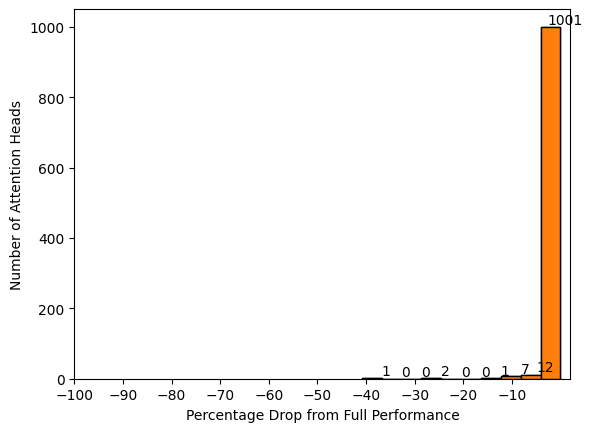

In [ ]:
lh_scores_drop = {key: min(0, val-100) for key, val in lh_scores.items()}
scores = list(lh_scores_drop.values())
plt.hist(scores, bins=10, edgecolor='black')
n, bins, patches = plt.hist(scores, bins=10, edgecolor='black')  # Adjust the number of bins as needed

# Annotating the histogram with the number of values in each bin
for i in range(len(n)):
    plt.text(bins[i]+5, n[i], str(int(n[i])), va='bottom', ha='center')

plt.xticks(range(-100, 0, 10))
plt.xlabel('Percentage Drop from Full Performance')
plt.ylabel('Number of Attention Heads')
# plt.title('Distribution of Attention Head Performance Drop Percentages')

# plt.show()

if save_files:
    pdf_filename = 'lh_scores_distribution.pdf'
    plt.savefig(pdf_filename)
    files.download(pdf_filename)

In [ ]:
scores = list(lh_scores_drop.values())
mean_score = statistics.mean(scores)
print("Mean of the scores:", mean_score)

if save_files:
    with open('numerals_lh_scores.pkl', 'wb') as file:
        pickle.dump(lh_scores, file)
        files.download('numerals_lh_scores.pkl')

Mean of the scores: -0.4185224212706089


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## plot heatmap

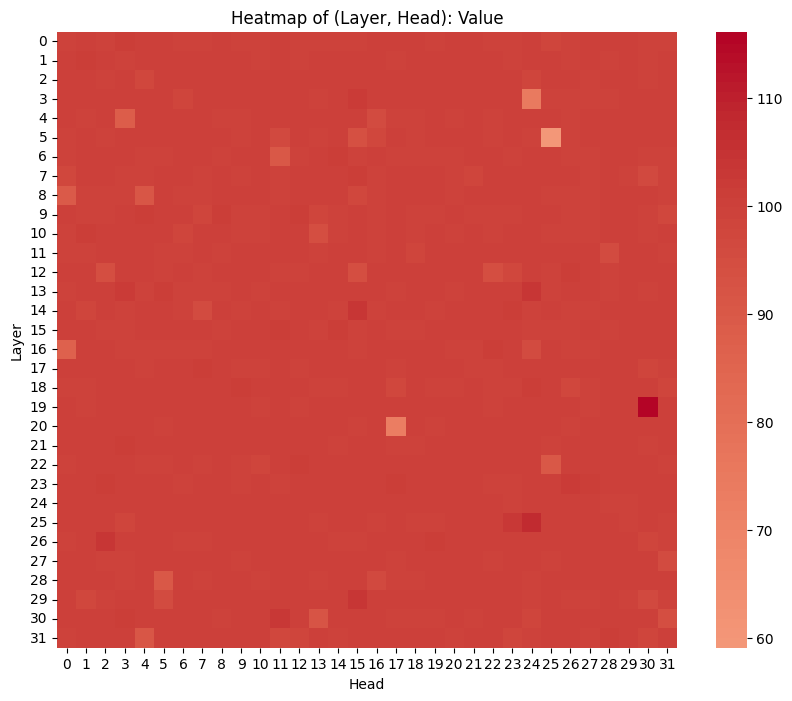

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert dictionary to a DataFrame
data_list = [(key[0], key[1], value) for key, value in lh_scores.items()]
df = pd.DataFrame(data_list, columns=['Layer', 'Head', 'Value'])

# Create a pivot table
pivot_table = df.pivot(index='Layer', columns='Head', values='Value').fillna(0)

# Plot the heatmap
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(pivot_table, cmap='coolwarm', center=0, annot=False, cbar=True)
plt.xlabel('Head')
plt.ylabel('Layer')
plt.title('Heatmap of (Layer, Head): Value')

# Rotate y-axis numbers to horizontal
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

plt.show()

# Find Impt MLPs from Full

In [ ]:
for i in range(32):
    lst = [layer for layer in range(32) if layer != i]
    perc_of_orig = ablate_MLP_from_full(lst, model, dataset, dataset_2, orig_score, print_output=False).item()
    print(i, perc_of_orig)

0 68.39082336425781
1 60.9903564453125
2 67.35907745361328
3 76.4286880493164
4 74.830078125
5 83.50626373291016
6 76.4582290649414
7 73.5766372680664
8 94.43434143066406
9 101.66463470458984
10 82.34976196289062
11 100.44725036621094
12 107.74789428710938
13 106.05551147460938
14 103.30465698242188
15 76.74903106689453
16 93.27847290039062
17 100.48667907714844
18 88.48347473144531
19 93.16832733154297
20 87.30072784423828
21 97.45310974121094
22 96.55979919433594
23 99.94934844970703
24 94.39239501953125
25 103.35821533203125
26 99.5173110961914
27 92.53862762451172
28 87.70771026611328
29 85.92241668701172
30 104.64595031738281
31 72.6233139038086


# Node Ablation Iteration

## new fns

In [ ]:
# from dataset import Dataset
# from transformer_lens import HookedTransformer, utils
# from transformer_lens.hook_points import HookPoint
# import einops
# from functools import partial
# import torch as t
# from torch import Tensor
# from typing import Dict, Tuple, List
# from jaxtyping import Float, Bool

# from node_ablation_fns import *

# def find_circuit_forw(model, dataset, dataset_2, heads_not_ablate=None, mlps_not_ablate=None, orig_score=100, threshold=10):
#     # threshold is T, a %. if performance is less than T%, allow its removal
#     # we don't ablate the curr circuits
#     if heads_not_ablate == []: # Start with full circuit
#         heads_not_ablate = [(layer, head) for layer in range(12) for head in range(12)]
#     if mlps_not_ablate == []:
#         mlps_not_ablate = [layer for layer in range(12)]

#     comp_scores = {}
#     for layer in range(0, 12):
#         for head in range(12):
#             print(layer, head)
#             if (layer, head) not in heads_not_ablate:
#                 continue

#             copy_heads_not_ablate = heads_not_ablate.copy()
#             copy_heads_not_ablate.remove((layer, head))

#             model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
#             ablated_model = add_ablation_hook_MLP_head(model, dataset_2, copy_heads_not_ablate, mlps_not_ablate)

#             new_logits = ablated_model(dataset.toks)
#             new_score = get_logit_diff(new_logits, dataset)
#             new_perc = 100 * new_score / orig_score
#             comp_scores[layer] = new_perc
#             print(f"(cand circuit / full) %: {new_perc:.4f}")
#             if (100 - new_perc) < threshold:
#                 heads_not_ablate.remove((layer, head))
#                 print("Removed:", (layer, head))
#             del(new_logits)

#         print(layer)
#         if layer in mlps_not_ablate:
#             copy_mlps_not_ablate = mlps_not_ablate.copy()
#             copy_mlps_not_ablate.remove(layer)

#             model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
#             ablated_model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, copy_mlps_not_ablate)

#             new_logits = ablated_model(dataset.toks)
#             new_score = get_logit_diff(new_logits, dataset)
#             new_perc = 100 * new_score / orig_score
#             comp_scores[(layer, head)] = new_perc
#             print(f"(cand circuit / full) %: {new_perc:.4f}")
#             if (100 - new_perc) < threshold:
#                 mlps_not_ablate.remove(layer)
#                 print("Removed: MLP ", layer)
#             del(new_logits)

#     return heads_not_ablate, mlps_not_ablate, new_perc, comp_scores

def find_circuit_backw(model, dataset, dataset_2, heads_not_ablate=None, mlps_not_ablate=None, orig_score=100, threshold=10):
    # threshold is T, a %. if performance is less than T%, allow its removal
    # we don't ablate the curr circuits
    if heads_not_ablate == []: # Start with full circuit
        heads_not_ablate = [(layer, head) for layer in range(32) for head in range(32)]
    if mlps_not_ablate == []:
        mlps_not_ablate = [layer for layer in range(32)]

    comp_scores = {}
    for layer in range(31, -1, -1):  # go thru all heads in a layer first
        # print(layer)
        # if layer in mlps_not_ablate:
        #     copy_mlps_not_ablate = mlps_not_ablate.copy()
        #     copy_mlps_not_ablate.remove(layer)

        #     model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
        #     ablated_model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, copy_mlps_not_ablate)

        #     new_logits = ablated_model(dataset.toks)
        #     new_score = get_logit_diff(new_logits, dataset)
        #     new_perc = 100 * new_score / orig_score
        #     comp_scores[layer] = new_perc
        #     print(f"(cand circuit / full) %: {new_perc:.4f}")
        #     if (100 - new_perc) < threshold:
        #         mlps_not_ablate.remove(layer)
        #         print("Removed: MLP ", layer)
        #     del(new_logits)

        for head in range(32):
            print(layer, head)
            if (layer, head) not in heads_not_ablate:
                continue

            copy_heads_not_ablate = heads_not_ablate.copy()
            copy_heads_not_ablate.remove((layer, head))

            model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

            """
            run the Nth dataset N times and sum up the logits for the N runs.
            Then take the final summed logit score for these N datasets, and
            take the mean over the number of samples for ALL datasets.
            """

            # lst = [(layer, head) for layer in range(32) for head in range(0, 32)]

            all_correct_logits = torch.tensor([], device='cuda:0')
            for ansLen, dataset in enumerate(clean_datasets):
                # model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook

                # CIRCUIT = {}
                # SEQ_POS_TO_KEEP = {}
                # list_tokens = tokenizer.tokenize(dataset.prompts[0]['text'])
                # for i, tok_as_str in enumerate(list_tokens):
                #     CIRCUIT['S'+str(i)] = lst
                #     SEQ_POS_TO_KEEP['S'+str(i)] = 'S'+str(i)

                dataset_2 = corrupted_datasets[ansLen]
                # model = add_ablation_hook_head(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
                model = add_ablation_hook_MLP_head(model, dataset_2, copy_heads_not_ablate, mlps_not_ablate)
                # ablated_model = model

                tokens = dataset.toks
                tokens = tokens.to("cuda" if torch.cuda.is_available() else "cpu")
                for runID in range(ansLen + 1):
                    # print(tokens.shape)
                    logits = model(tokens)

                    ansTok_IDs = torch.tensor(dataset.corr_tokenIDs[ansLen])
                    correct_logits = logits[range(logits.size(0)), -1, ansTok_IDs]  # not next_token, as that's what's pred, not the token to measure
                    # print(ansLen, runID, correct_logits)
                    if runID == 0:
                        total_logits_for_ansLen = correct_logits
                    else:
                        total_logits_for_ansLen += correct_logits

                    next_token = logits[range(logits.size(0)), -1].argmax(dim=-1) # Get the predicted token at the end of our sequence

                    next_token_reshaped = next_token.view(-1, 1)
                    tokens = torch.cat((tokens, next_token_reshaped), dim=1)

                    # if runID > 0 and runID < ansLen:
                    #     i += 1
                    #     CIRCUIT['S'+str(i)] = lst
                    #     SEQ_POS_TO_KEEP['S'+str(i)] = 'S'+str(i)
                    #     # model = add_ablation_hook_head(model, means_dataset=dataset_2, circuit=CIRCUIT, seq_pos_to_keep=SEQ_POS_TO_KEEP)
                    #     ablated_model = add_ablation_hook_MLP_head(model, dataset_2, copy_heads_not_ablate, mlps_not_ablate)

                all_correct_logits = torch.cat((all_correct_logits, total_logits_for_ansLen))

            new_score = all_correct_logits.mean()

            new_perc = 100 * new_score / orig_score
            comp_scores[(layer, head)] = new_perc
            print(f"(cand circuit / full) %: {new_perc:.4f}")
            if (100 - new_perc) < threshold:
                heads_not_ablate.remove((layer, head))
                print("Removed:", (layer, head))
            del(logits)

    return heads_not_ablate, mlps_not_ablate, new_score, comp_scores

## run

In [ ]:
# threshold = 20
# curr_circ_heads = []
# curr_circ_mlps = []
# prev_score = 100
# new_score = 0
# iter = 1
# all_comp_scores = []
# while prev_score != new_score:
#     print('\nbackw prune, iter ', str(iter))
#     old_circ_heads = curr_circ_heads.copy() # save old before finding new one
#     old_circ_mlps = curr_circ_mlps.copy()
#     curr_circ_heads, curr_circ_mlps, new_score, comp_scores = find_circuit_backw(model, dataset, dataset_2, curr_circ_heads, curr_circ_mlps, orig_score, threshold)
#     if old_circ_heads == curr_circ_heads and old_circ_mlps == curr_circ_mlps:
#         break
#     all_comp_scores.append(comp_scores)
#     print('\nfwd prune, iter ', str(iter))
#     # track changes in circuit as for some reason it doesn't work with scores
#     old_circ_heads = curr_circ_heads.copy()
#     old_circ_mlps = curr_circ_mlps.copy()
#     curr_circ_heads, curr_circ_mlps, new_score, comp_scores = find_circuit_forw(model, dataset, dataset_2, curr_circ_heads, curr_circ_mlps, orig_score, threshold)
#     if old_circ_heads == curr_circ_heads and old_circ_mlps == curr_circ_mlps:
#         break
#     all_comp_scores.append(comp_scores)
#     iter += 1

In [ ]:
threshold = 20
curr_circ_heads = []
curr_circ_mlps = []
prev_score = 100
new_score = 0
iter = 1
all_comp_scores = []
# while prev_score != new_score:
# print('\nbackw prune, iter ', str(iter))
old_circ_heads = curr_circ_heads.copy() # save old before finding new one
old_circ_mlps = curr_circ_mlps.copy()
curr_circ_heads, curr_circ_mlps, new_score, comp_scores = find_circuit_backw(model, dataset, dataset_2, curr_circ_heads, curr_circ_mlps, orig_score, threshold)

31 0
9
13
(cand circuit / full) %: 99.9757
Removed: (31, 0)
31 1
9
13
(cand circuit / full) %: 100.0684
Removed: (31, 1)
31 2
9
13
(cand circuit / full) %: 100.2140
Removed: (31, 2)
31 3
9
13
(cand circuit / full) %: 100.2181
Removed: (31, 3)
31 4
9
13
(cand circuit / full) %: 104.2151
Removed: (31, 4)
31 5
9
13
(cand circuit / full) %: 104.3391
Removed: (31, 5)
31 6
9
13
(cand circuit / full) %: 103.5611
Removed: (31, 6)
31 7
9
13
(cand circuit / full) %: 103.4942
Removed: (31, 7)
31 8
9
13
(cand circuit / full) %: 104.3778
Removed: (31, 8)
31 9
9
13
(cand circuit / full) %: 104.3259
Removed: (31, 9)
31 10
9
13
(cand circuit / full) %: 104.1065
Removed: (31, 10)
31 11
9
13
(cand circuit / full) %: 102.8282
Removed: (31, 11)
31 12
9
13
(cand circuit / full) %: 102.7262
Removed: (31, 12)
31 13
9
13
(cand circuit / full) %: 102.3558
Removed: (31, 13)
31 14
9
13
(cand circuit / full) %: 101.3515
Removed: (31, 14)
31 15
9
13
(cand circuit / full) %: 100.5166
Removed: (31, 15)
31 16
9
13
(c

In [ ]:
with open('numwords_b_20_scores.pkl', 'wb') as file:
    pickle.dump(all_comp_scores, file)
files.download('numwords_b_20_scores.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
curr_circ_heads

[(0, 0),
 (0, 1),
 (0, 3),
 (0, 7),
 (0, 10),
 (0, 11),
 (0, 13),
 (0, 14),
 (0, 15),
 (0, 19),
 (0, 21),
 (0, 22),
 (0, 24),
 (0, 25),
 (0, 26),
 (0, 27),
 (0, 30),
 (0, 31),
 (1, 1),
 (1, 2),
 (1, 6),
 (1, 8),
 (1, 10),
 (1, 22),
 (1, 25),
 (1, 26),
 (1, 28),
 (1, 29),
 (1, 31),
 (2, 2),
 (2, 4),
 (2, 5),
 (2, 6),
 (2, 7),
 (2, 11),
 (2, 13),
 (2, 14),
 (2, 15),
 (2, 16),
 (2, 17),
 (2, 18),
 (2, 19),
 (2, 20),
 (2, 21),
 (2, 23),
 (2, 27),
 (2, 29),
 (2, 30),
 (3, 1),
 (3, 3),
 (3, 5),
 (3, 7),
 (3, 10),
 (3, 13),
 (3, 17),
 (3, 20),
 (3, 21),
 (3, 22),
 (3, 30),
 (3, 31),
 (4, 0),
 (4, 2),
 (4, 3),
 (4, 16),
 (5, 5),
 (5, 13),
 (5, 15),
 (5, 16),
 (5, 18),
 (5, 19),
 (5, 20),
 (5, 21),
 (5, 22),
 (5, 23),
 (5, 24),
 (5, 25),
 (5, 26),
 (5, 28),
 (5, 29),
 (6, 0),
 (6, 1),
 (6, 5),
 (6, 6),
 (6, 7),
 (6, 9),
 (6, 11),
 (6, 12),
 (6, 14),
 (6, 15),
 (6, 18),
 (6, 19),
 (6, 20),
 (6, 23),
 (6, 24),
 (6, 25),
 (6, 30),
 (7, 0),
 (7, 1),
 (7, 5),
 (7, 6),
 (7, 7),
 (7, 8),
 (7, 9),
 (7,

In [ ]:
curr_circ_mlps

## Find most impt heads from circ

In [86]:
model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, curr_circ_heads, curr_circ_mlps)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

13
(cand circuit / full) %: -1.1847


In [ ]:
lh_scores = {}
for lh in curr_circ_heads:
    copy_circuit = curr_circ_heads.copy()
    copy_circuit.remove(lh)
    print("removed: " + str(lh))
    model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
    model = add_ablation_hook_MLP_head(model, dataset_2, copy_circuit, curr_circ_mlps)

    new_logits = model(dataset.toks)
    new_score = get_logit_diff(new_logits, dataset).item()
    new_perc = 100 * new_score / orig_score
    print(f"(cand circuit / full) %: {new_perc:.4f}")
    lh_scores[lh] = new_perc

removed: (0, 0)
13
(cand circuit / full) %: -1.0161
removed: (0, 1)
13
(cand circuit / full) %: -0.7140
removed: (0, 3)
13
(cand circuit / full) %: -0.5196
removed: (0, 7)
13
(cand circuit / full) %: -0.7435
removed: (0, 10)
13
(cand circuit / full) %: -1.0669
removed: (0, 11)
13
(cand circuit / full) %: -0.6534
removed: (0, 13)
13
(cand circuit / full) %: -1.1450
removed: (0, 14)
13
(cand circuit / full) %: 0.0138
removed: (0, 15)
13
(cand circuit / full) %: 0.2262
removed: (0, 19)
13
(cand circuit / full) %: -1.2796
removed: (0, 21)
13
(cand circuit / full) %: -1.3767
removed: (0, 22)
13
(cand circuit / full) %: -0.9112
removed: (0, 24)
13
(cand circuit / full) %: -0.4480
removed: (0, 25)
13
(cand circuit / full) %: -0.1063
removed: (0, 26)
13
(cand circuit / full) %: -1.1238
removed: (0, 27)
13
(cand circuit / full) %: -1.1644
removed: (0, 30)
13
(cand circuit / full) %: -0.7309
removed: (0, 31)
13
(cand circuit / full) %: -0.2451
removed: (1, 1)
13
(cand circuit / full) %: -0.6524


In [ ]:
sorted_lh_scores = dict(sorted(lh_scores.items(), key=lambda item: item[1]))
for lh, score in sorted_lh_scores.items():
    print(lh, -round(circ_score-score.item(), 2))

# Run on other task's circuits

In [ ]:
heads_not_ablate = [(0, 1), (1, 5), (4, 4), (4, 10), (5, 0), (6, 1), (6, 6), (6, 10), (7, 11), (8, 1), (8, 6), (8, 8), (8, 9), (9, 1)]
mlps_not_ablate = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11]

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: 81.0075


In [ ]:
# numwords
heads_not_ablate = [(0, 1), (1, 5), (4, 4), (4, 10), (5, 8), (6, 1), (6, 6), (6, 10), (7, 2), (7, 6), (7, 11), (8, 1), (8, 6), (8, 8), (8, 9), (8, 11), (9, 1), (9, 5), (9, 7)]
mlps_not_ablate = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: 87.3488


In [ ]:
# months
heads_not_ablate = [(0, 1), (0, 5), (4, 4), (6, 1), (6, 6), (6, 10), (7, 6), (7, 9), (7, 10), (7, 11), (8, 8), (9, 1), (10, 7)]
mlps_not_ablate = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10]

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: 43.7440


In [ ]:
CIRCUIT = {
    "name mover": [(9, 9), (10, 0), (9, 6)],
    "backup name mover": [(10, 10), (10, 6), (10, 2), (10, 1), (11, 2), (9, 7), (9, 0), (11, 9)],
    "negative name mover": [(10, 7), (11, 10)],
    "s2 inhibition": [(7, 3), (7, 9), (8, 6), (8, 10)],
    "induction": [(5, 5), (5, 8), (5, 9), (6, 9)],
    "duplicate token": [(0, 1), (0, 10), (3, 0)],
    "previous token": [(2, 2), (4, 11)],
}

import itertools
a = [val for val in CIRCUIT.values()]
IOI_heads = list(itertools.chain.from_iterable(a))

mlps_not_ablate = list(range(12))

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, IOI_heads, mlps_not_ablate)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: -6.6992


In [ ]:
### months w/ MLP 11

heads_not_ablate = [(0, 1), (4, 4), (4, 10), (6, 1), (6, 6), (6, 10), (7, 2), (7, 10), (7, 11), (8, 8), (9, 1)]
mlps_not_ablate = [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11] # incl 5 makes it 66.1155%

model.reset_hooks(including_permanent=True)  #must do this after running with mean ablation hook
model = add_ablation_hook_MLP_head(model, dataset_2, heads_not_ablate, mlps_not_ablate)

new_logits = model(dataset.toks)
new_score = get_logit_diff(new_logits, dataset)
circ_score = (100 * new_score / orig_score).item()
print(f"(cand circuit / full) %: {circ_score:.4f}")

(cand circuit / full) %: 37.7001
